#### 1.1 Dataset

In [46]:
# matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io #Used to load the OCTAVE *.mat files
import scipy.misc #Used to show matrix as an image
import matplotlib.cm as cm #Used to display images in a specific colormap
import random #To pick random images to display
from scipy.special import expit #Vectorized sigmoid function
from scipy.optimize import minimize # for minimizing the cost function

In [54]:
datafile = 'data/ex3data1.mat'
mat = scipy.io.loadmat( datafile )
X, y = mat['X'], mat['y']
y = y.ravel() # turn y into a 1d array
#Insert a column of 1's to X as usual
X = np.insert(X,0,1,axis=1)
[m,n] = X.shape  
# print "'y' shape: %s. Unique elements in y: %s"%(mat['y'].shape,np.unique(mat['y']))
# print "'X' shape: %s. X[0] shape: %s"%(X.shape,X[0].shape)
#X is 5000 images. Each image is a row. Each image has 400 pixels unrolled (20x20)
#y is a classification for each image. 1-10, where "10" is the handwritten "0"

In [56]:
n

401

#### 1.2 visualizing data

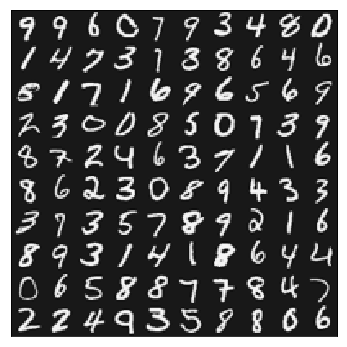

In [30]:
from PIL import Image

def getDatumImg(row):
    """
    Function that is handed a single np array with shape 1x400,
    crates an image object from it, and returns it
    """
    width, height = 20, 20
    square = row[1:].reshape(width,height)
    return square.T
    
def displayData(indices_to_display = None):
    """
    Function that picks 100 random rows from X, creates a 20x20 image from each,
    then stitches them together into a 10x10 grid of images, and shows it.
    """
    width, height = 20, 20
    nrows, ncols = 10, 10
    if not indices_to_display:
        indices_to_display = random.sample(range(X.shape[0]), nrows*ncols)
        
    big_picture = np.zeros((height*nrows,width*ncols))
    
    irow, icol = 0, 0
    for idx in indices_to_display:
        if icol == ncols:
            irow += 1
            icol  = 0
        iimg = getDatumImg(X[idx])
        big_picture[irow*height:irow*height+iimg.shape[0],icol*width:icol*width+iimg.shape[1]] = iimg
        icol += 1
    fig = plt.figure(figsize=(6,6))
#     img = scipy.misc.toimage( big_picture )
    img = Image.fromarray(big_picture)
    plt.imshow(img,cmap = cm.Greys_r)
    plt.xticks([])
    plt.yticks([])

displayData()

#### 1.3 Compute cost function

In [353]:
def h(theta,X):
    
    """
        theta: 1d array of n
        X: 2d of m by n
    """
    
    return expit(X @ theta) # return a 1d array of m

def costFunction(theta,X,y,mylambda = 0):
    
    """
        X: m by n
        y: m
        theta: n
        h: m
    """
    m = y.size
    term1 = np.log(h(theta,X)) @ (-y)
    term2 = np.log(1 - h(theta,X)) @ (1 - y)
    rgterm = (mylambda / (2 * m)) * (theta @ theta)
    
    return ((term1 - term2) / m + rgterm)


def gradFunction(theta,X,y,mylambda = 0):
    
    """
        X: m by n
        y: m
        theta: n
        h: m
    """
    
    m = y.size
    grad = (X.T @ (h(theta,X) - y)) / m + (mylambda / m) * theta  # for j >= 1
    grad[0] = (X[:,0] @ (h(theta,X) - y)) / m  # for j = 0
    
    return grad   # return a 1d array of n

from scipy import optimize

def minicost(theta0,myX,myy,mylambda = .0):
    """
        minimizing the cost function
    """
#     theta0 = np.zeros(myX.shape[1])
    
    result = minimize(costFunction, x0=theta0, args=(myX, myy, mylambda), method='CG',
                      jac = gradFunction, options={'maxiter':50,'disp':True})
#     result = optimize.fmin_cg(costFunction, fprime=gradFunction, x0=theta0,
#                               args=(myX, myy, mylambda), maxiter=50, disp=True, full_output=True)
    return result.x # return the theta (1d array of n)

#### 1.4 One-vs-all Classification

In [334]:
# example functions   copied from other guys
def optimizeTheta(mytheta,myX,myy,mylambda=0.):
    result = optimize.fmin_cg(costFunction, fprime=gradFunction, x0=mytheta, \
                              args=(myX, myy, mylambda), maxiter=50, disp=True,\
                              full_output=True)
    return result[0], result[1]

def buildTheta():
    """
    Function that determines an optimized theta for each class
    and returns a Theta function where each row corresponds
    to the learned logistic regression params for one class
    """
    mylambda = 0.
    initial_theta = np.zeros((X.shape[1],1)).reshape(-1)
    Theta = np.zeros((10,X.shape[1]))
    for i in range(10):
        iclass = i if i else 10 #class "10" corresponds to handwritten zero
        print(f"Optimizing for handwritten number {i}")
        logic_Y = np.array([1 if x == iclass else 0 for x in y])#.reshape((X.shape[0],1))
        itheta, imincost = optimizeTheta(initial_theta,X,logic_Y,mylambda)
        Theta[i,:] = itheta
    print("Done!")
    return Theta

In [354]:
# Train the model

mylambda = 0.
initial_theta = np.zeros((X.shape[1],1)).reshape(-1)

theta = np.zeros((10,X.shape[1]))

for k in range(10):
    iclass = k if k else 10 #class "10" corresponds to handwritten zero
    logic_Y = np.zeros(y.size)
    logic_Y[y == iclass] = 1
    logic_Y = logic_Y.astype("float64")  # IMPORTANT.Otherwise,the optimization will fail due to lack of precision
    print(f"Optimizing number {k}")
    theta[k,:] = minicost(initial_theta,X,logic_Y,0)
print("Done!")


# mylambda = 0.
# initial_theta = np.zeros((X.shape[1],1)).reshape(-1)
# theta1 = np.zeros((10,X.shape[1]))
# for i in range(10):
#     iclass = i if i else 10 #class "10" corresponds to handwritten zero
#     print(f"Optimizing for handwritten number {i}")
#     logic_Y = np.array([1 if x == iclass else 0 for x in y])#.reshape((X.shape[0],1))
#     itheta, imincost = optimizeTheta(initial_theta,X,logic_Y,mylambda)
#     theta1[i,:] = itheta
# print("Done!")


Optimizing number 0
         Current function value: 0.005304
         Iterations: 50
         Function evaluations: 180
         Gradient evaluations: 180
Optimizing number 1
         Current function value: 0.009918
         Iterations: 50
         Function evaluations: 182
         Gradient evaluations: 182
Optimizing number 2
         Current function value: 0.056592
         Iterations: 50
         Function evaluations: 136
         Gradient evaluations: 136
Optimizing number 3
         Current function value: 0.060411
         Iterations: 50
         Function evaluations: 138
         Gradient evaluations: 138
Optimizing number 4
         Current function value: 0.035203
         Iterations: 50
         Function evaluations: 153
         Gradient evaluations: 153
Optimizing number 5
         Current function value: 0.058138
         Iterations: 50
         Function evaluations: 133
         Gradient evaluations: 133
Optimizing number 6
         Current function value: 0.008167
  

In [355]:
theta[:,:10]

array([[-8.01764328e+00,  0.00000000e+00,  0.00000000e+00,
        -2.36195613e-07, -1.84649166e-05,  2.29359887e-04,
         2.20918842e-03,  7.04702106e-04, -8.72781457e-04,
        -1.88104508e-03],
       [-3.06505513e+00,  0.00000000e+00,  0.00000000e+00,
         7.96622619e-05, -7.35886339e-04, -8.04107764e-04,
         1.24729086e-03, -1.58304696e-02, -3.65975542e-04,
         5.73980908e-04],
       [-3.41762681e+00,  0.00000000e+00,  0.00000000e+00,
        -2.58733878e-05,  3.62169342e-04, -8.80015677e-04,
        -1.56156299e-02, -8.06626673e-03, -1.06391173e-02,
        -1.20780010e-03],
       [-4.95824479e+00,  0.00000000e+00,  0.00000000e+00,
        -1.09794265e-05, -2.58870644e-04,  5.99744682e-03,
         2.70263596e-02, -3.13288097e-02, -6.79257337e-03,
         6.66405832e-04],
       [-2.27308071e+00,  0.00000000e+00,  0.00000000e+00,
        -4.30839894e-06, -1.79852680e-05,  1.14012193e-03,
        -6.37806391e-04,  1.22507498e-03,  4.38991785e-02,
         3.

In [372]:
# Use the model to predict

def predict(xrow,mytheta):
    
    prob = []
    for i in range(10):
        prob.append(h(mytheta[i,:],xrow))
#     print(str(prob))
    pre = np.argmax(prob)
    print(f"Predicted number: {pre}, with probability {prob[pre]*100:.2f} %")
    return 

def checkresult(X,y,mytheta,nrow):
    img = Image.fromarray(getDatumImg(X[nrow]))
    plt.imshow(img,cmap = cm.Greys_r)
    predict(X[nrow],mytheta)


Predicted number: 9, with probability 98.83 %


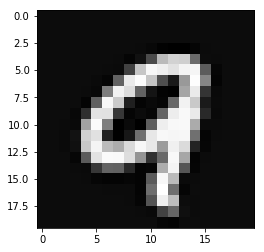

In [379]:
checkresult(X,y,theta,4900)

In [358]:
def predictOneVsAll(myTheta,myrow):
    """
    Function that computes a hypothesis for an individual image (row in X)
    and returns the predicted integer corresponding to the handwritten image
    """
    classes = [10] + list(range(1,10))
    hypots  = [0]*len(classes)
    #Compute a hypothesis for each possible outcome
    #Choose the maximum hypothesis to find result
    for i in range(len(classes)):
        hypots[i] = h(myTheta[i],myrow)
    return classes[np.argmax(np.array(hypots))]    
# "You should see that the training set accuracy is about 94.9%"

n_correct, n_total = 0., 0.
incorrect_indices = []
for irow in range(X.shape[0]):
    n_total += 1
    if predictOneVsAll(theta,X[irow]) == y[irow]: 
        n_correct += 1
    else: incorrect_indices.append(irow)
print(f"Training set accuracy: {(100*(n_correct/n_total))}")

Training set accuracy: 95.36
